# <center><span style="color: #7088b8; font-weight: normal; font-size: xxx-large;">Vectorizing recipes as<br><em>bags of ingredients</em></span></center>

This tutorial introduces the basics of turning data into vectors for visualization, so as to gain insight into the innate patterns of the data.

# Context: I'm growing hungry

We pursue here the [purpose](README.md#purpose) of surveying a dataset:
we want to observe which data elements are similar to which others, and how.

In [1]:
import bokeh.io
import glasbey as gb
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import panel as pn
from pathlib import Path
import thisnotthat as tnt
import umap
import vectorizers as vz
import vectorizers.transformers as vzt
from zipfile import ZipFile

The following cell sets up a notebook extension to enable data visualization tools.

In [ ]:
bokeh.io.output_notebook()
pn.extension()

The data we will look at here consists in culinary recipes,
for each of which we have the list of ingredients.

In [3]:
path_recipes = Path("data/recipes.zip")
with ZipFile(path_recipes) as file_data:
    data = pd.DataFrame(json.loads(file_data.read("train.json")))
data

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."


Let's draw attention to the structure of the dataset above.
Each row of the `data` table corresponds to one recipe.
Let's look at the very first recipe.

In [4]:
data.iloc[0]

id                                                         10259
cuisine                                                    greek
ingredients    [romaine lettuce, black olives, grape tomatoes...
Name: 0, dtype: object

The recipe is expressed by three *attributes*.
The first is called **id**, and it is an integer.
Given the name, it's probably a unique identifier for each recipe.
Let's check.

In [5]:
len(set(data["id"]))

39774

So these are the "names" of the recipes, so to speak.
The second attribute is called <a id="attribute-cuisine"></a>**cuisine**, and it is a single word.
Look up how many types of cuisine we have.

In [6]:
len(set(data["cuisine"]))

20

Only 20 types.
We can understand these as recipe _categories_.
The third attribute is called **ingredients**.
It is &mdash; surprise! &mdash; the list of ingredients processed into the recipe.

In [7]:
data.loc[0]["ingredients"]

['romaine lettuce',
 'black olives',
 'grape tomatoes',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo beans',
 'feta cheese crumbles']

How many lists of ingredients are there?
(Be patient, answering this question takes a while.)

In [8]:
%%time
len(data["ingredients"].apply(sorted).drop_duplicates())

CPU times: user 20.5 s, sys: 116 ms, total: 20.6 s
Wall time: 20.3 s


39243

The answer is: nearly as many lists of ingredients as we have recipes.
<a id="recipe-list-ingredients"></a>Therefore, we can say that each recipe is **characterized** by its list of ingredients (and its numerical ID).
Any gourmet looking at this will say:

>*Wait a second, decorporated math person: a recipe is characterized by its ingredients, yes, but also by the steps for processing them.*

Of course, my dear gourmet, but here's a math person trick: *let's assume we don't care*!
A statement like *a recipe is a list of ingredients* is an assumption we can use to build a **model** for recipes.
As statistician George Box is [oft quoted](https://en.wikipedia.org/wiki/All_models_are_wrong):

> All models are wrong, some are useful.

Perhaps this wrong assertion on recipes can still give us some insight into the whole set of recipes we have.
So we carry on with the following two observations:

1. In our data, the **cuisine** expresses a category of the recipe.
2. In our data, the **ingredients** list characterizes each recipe.

## *Steak, blé d'Inde, patates*

Afford this author a little digression.
One of the best sitcom to be produced in Québec was titled [*La Petite Vie*](https://fr.wikipedia.org/wiki/La_Petite_Vie).
It ran for four seasons, from 1993 to 1998.
Ask most Quebecers who watched any television in the 90s, there is likely a gag from this show they remember fondly.

My own favorite from this show has to be the *pâté chinois* running gag.
Pâté chinois is the simpler, peasantly Quebecer version of shepherd's pie.
It is made as a baked dish in three layers: minced hamburger at the bottom, cream corn in the middle, and mashed potatoes on top.
In short: *mince, corn, taters*.
In La Petite Vie, the character of Thérèse is the ditzy daughter of Popa and Moman.
She tries again and again to make pâté chinois, but manages to ruin it with ever sillier mistakes:
laying ingredients side by side instead of as superposed layers,
replacing corn with popcorn,
putting sprinkles on top,
and so on.
And each time her mom chides her softly:

> Moman: *C'est pas compliqué, Thérèse: steak, blé d'Inde, patates.*
>
> Thérèse: *Steak, blé d'Inde, patates! Steak, blé d'Inde, patates!*

Translated: "This isn't hard, Thérèse: mince, corn, taters!"

Please indulge a short watch:

In [9]:
%%html
<iframe src="https://www.facebook.com/plugins/video.php?height=314&href=https%3A%2F%2Fwww.facebook.com%2FArchivesRadioCanada%2Fvideos%2F223729693365497%2F&show_text=false&width=560&t=0" width="560" height="314" style="border:none;overflow:hidden" scrolling="no" frameborder="0" allowfullscreen="true" allow="autoplay; clipboard-write; encrypted-media; picture-in-picture; web-share" allowFullScreen="true"></iframe>

The point of this is that members of the Tutte Institute get to field many data science questions.
Many take the form

> I have data, lots of data! and I want to find the X in it. What model should I make? Should I use fashionable library Y? Should I do AI?

Our answer would be: start with **steak, blé d'Inde, patates** &mdash; but not with food, of course.
If you can describe your data as:

> Each data object is a bag of elements,

then the first thing that should be tried, every time, without exception, is this simple, easy, 3-step sequential recipe.

1. Vectorize by counting unique components of each data object;
2. Information weight transform;
3. Similarity-preserving dimension reduction, preferrably using UMAP.

This embeds the data objects in a two-dimensional vector space.
In other words, **it transforms every object into a point on a plane.**
This embedding projects the local similarity structure of the dataset onto the Euclidean distance between the 2D vectors.
In other words, **similar data objects become points that are close to each other on the plane.**

Let's repeat this, it is very important.
The model assumption above is very light and simple.
If the dataset is made of objects that are sequences, lists, arrays, sets, logs, collections of smaller elements, such as words, tokens, integers, booleans, dates, paths, hashes, symbols, hieroglyphs;
then one can say *each data object is a bag of elements*.

Then, automatically, one should think &mdash; C'est pas compliqué: Thérèse &mdash; **vectors, infoweight, UMAP**.

This recipe provides a model that, when used for analyzing a corpus of short text documents, is called a *bag of words*.
While it is simple and easy to process (given the appropriate tools -- UMAP is not a trivial computation),
it can be surprisingly effective at revealing correlation phenomena among the dataset &mdash;
groups of similar data objects.
The simplicity of bags of words models make them paramount as first thing to compute,
so that we can compare it to the results of any smarter approach.
The bag of words is the minimum baseline that smart should beat.

So, back to our recipes dataset.
We said [earlier](#recipe-list-ingredients) that *a recipe is a list of ingredients*.
Since every ingredient is a definitively a discrete object,
we could rephrase as

> A recipe is a bag of ingredients.

Ok, then we compute a bag of words model, at least as a first approximation. Vectors, infoweight, UMAP.

# Step 1: from lists of ingredients to vectors

If you have gone through some machine learning tutorial before,
it likely started by explaining how each data object was characterized by _numerical features_ &mdash; 
numbers measuring various properties of the object.
With a little bit of mathematical inclination,
the reader sees a bunch of numbers and construes they could be expressed into a vector.
Easy!

But how does one get number vectors when objects are variable-length sequences of not-numbers?
The trick then is to **count the components making up the sequences**.
Take a sentence, for example:

> Sentence (A): The quick brown fox jumps over the lazy dog.

It is a sequence of words.
Let's drop all punctuation and letter case, and count the words that make up the sentence.

|     | brown | dog | fox | jumps | lazy | over | quick | the |
|-----|-------|-----|-----|-------|------|------|-------|-----|
| (A) | 1     | 1   | 1   | 1     | 1    | 1    | 1     | 2   |

So we now have a vector representing the sentence: $(1, 1, 1, 1, 1, 1, 1, 2)$.
Yes, it ignores the order of the words, it also ignores grammatical sentence.
It's wrong! But maybe it can be useful.
Add another sentence:

> Sentence (B): The quick brown dogs surround the fox in a copse of trees.

Sentence (B) carries a few words that were not part of sentence (A).
It's ok, let's just extend the set of columns, and thus the dimension of the vectors.

|     | a | brown | copse | dog | dogs | fox | in | jumps | lazy | of | over | quick | surround | the | trees |
|-----|---|-------|-------|-----|------|-----|----|-------|------|----|------|-------|----------|-----|-------|
| (A) | 0 | 1     | 0     | 1   | 0    | 1   | 0  | 1     | 1    | 0  | 1    | 1     | 0        | 2   | 0     |
| (B) | 1 | 1     | 1     | 0   | 1    | 1   | 1  | 0     | 0    | 1  | 0    | 1     | 1        | 2   | 1     |

Each row of this table is a vector representing each sentence, respectively.
This transformation of sequences of components into sparse vectors of counts is called **one-hot encoding**.
The dimension of these vectors is dictated by the size of the union of the set of words making up all the sentences crunched into our model:
this set of words is the model's **vocabulary**.
We draw *similarity* between these two sentences by the number of words they share: `brown`, `fox`, `quick` and `the`.
We draw *dissimilarity* between these two sentences by the number of words they don't have in common: `a`, `copse`, and so on.
Interestingly, despite both sentences being about dogs and foxes, the words `dog` and `dogs` are not exactly the same, and so they induce a dissimilarity between the sentences.
It is a quirk of this model.
Let's roll with it: simplicity desserves attention.

The Tutte Institute has come up with an efficient Python library called [Vectorizers](https://vectorizers.readthedocs.io/en/latest/) to perform variants of one-hot encoding.
Coming back to our recipe dataset.
Recall that each recipe is characterized by its list of ingredients:

In [10]:
data["ingredients"]

0        [romaine lettuce, black olives, grape tomatoes...
1        [plain flour, ground pepper, salt, tomatoes, g...
2        [eggs, pepper, salt, mayonaise, cooking oil, g...
3                      [water, vegetable oil, wheat, salt]
4        [black pepper, shallots, cornflour, cayenne pe...
                               ...                        
39769    [light brown sugar, granulated sugar, butter, ...
39770    [KRAFT Zesty Italian Dressing, purple onion, b...
39771    [eggs, citrus fruit, raisins, sourdough starte...
39772    [boneless chicken skinless thigh, minced garli...
39773    [green chile, jalapeno chilies, onions, ground...
Name: ingredients, Length: 39774, dtype: object

In [11]:
data.iloc[0]

id                                                         10259
cuisine                                                    greek
ingredients    [romaine lettuce, black olives, grape tomatoes...
Name: 0, dtype: object

This is exactly the format expected by `vectorizers.NgramVectorizer`: a list of sequences of strings,
each string representing a characterizing component of the data object.
Let's crunch.

In [12]:
%%time
vz_ngram = vz.NgramVectorizer().fit(data["ingredients"])
vz_ngram

CPU times: user 3.14 s, sys: 110 ms, total: 3.25 s
Wall time: 3.24 s


NgramVectorizer()

This instance of the `NgramVectorizer` class carries the two key elements we expect out of one-hot encoding.
The first is the table of counts, also called the **weight matrix**.

In [13]:
vz_ngram._train_matrix

<39774x6714 sparse matrix of type '<class 'numpy.float32'>'
	with 428249 stored elements in Compressed Sparse Row format>

There's many things we should observe about this table.
First, its dimensions.
It has 39774 rows: one per recipe, as we expected.
It then has 6714 columns: this corresponds to the size of our vocabulary.

Now one may ask: wait, are we holding this array wholly in RAM?
Presuming 4-byte number representations, this would take up

In [14]:
MB = 1 << 20
np.prod(vz_ngram._train_matrix.shape) * 4 / MB

1018.6868133544922

megabytes!
Yes, we're now in the third decade of the 21st century, but that's still quite a chunk of my machine's working memory.
The answer to this question is no: we are using a **sparse matrix representation**.
The object `vz_ngram._train_matrix` looks and talks like an two-dimension array,
but under the hood,
it avoids representing the zeros in the matrix as much as it can get away with.
To wit, we can ask this object how much memory it's using:

In [15]:
vz_ngram._train_matrix.data.nbytes / MB

1.6336402893066406

So really, a paltry 1.6 megabyte.
Sparse matrix representations are critical to the vectorization of arbitrary-length sequence datasets,
where very large vectors composed of more than 99% zeros are commonplace.

The second key element that the fit `NgramVectorizer` instance holds for us is the vocabulary.
It represents it as a mapping between ingredients and indices of columns in the count matrix.
This mapping is organized as a pair of dictionaries:
`column_label_dictionary_` maps from ingredient to column index,
while `column_index_dictionary_` maps from column index to ingredient.

In [16]:
len(vz_ngram.column_index_dictionary_), len(vz_ngram.column_label_dictionary_)

(6714, 6714)

Observe how both match the number of columns of `vz_ngram._train_matrix`.
We can use this dictionaries to translate between counts and sequences.
Recall the very first recipe of the dataset:

In [17]:
ing_first = data.iloc[0]["ingredients"]
ing_first

['romaine lettuce',
 'black olives',
 'grape tomatoes',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo beans',
 'feta cheese crumbles']

Its component counts should all be 1.0:

In [18]:
counts_first = np.array(vz_ngram._train_matrix[0, :].todense()).squeeze()  # Index queries requires breaking out of the sparse representation.
counts_first[[vz_ngram.column_label_dictionary_[ing] for ing in ing_first]]

array([1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

# Step 2: the information weight transform

So far, we have been characterizing each object of the dataset by the number of occurrences of each component object.
This like counting the words of a sentence, without regard to order, letter case or punctuation.
Now, if I were to point at a some book of 10,000 sentences, and ask "what do these sentences have in common?"
The data scientist would try and figure out the most common word between them.
The answer would be:

<center><strong>the</strong></center>

In all datasets such that we can wrangle with vectors-infoweight-UMAP,
there are these *stop words* that are ubiquitous and useless towards expressing the purpose of the data.
We don't want to put *too much weight* on these components when analyzing the correlations between our data objects.

Another problematic example is words that occur only once or twice among our 10,000 sentences.
For instance, let's say two sentences contain the word `constitution`.
Are they about nation-building legal documents?
Or about the vigor of people?
Or about the make-up of chemicals?
We can't know, as out of as many as 10,000 sentences,
there may simply not be enough further context to figure out the semantic contribution of these occurrences of `constitution`.
So if we care about the similarity structure between our sentences,
let's not put *too much weight* on such very rare words.

The **information weight transform** is a mathematical device for lowering the importance of those components that bring too little information to the similarity analysis between data objects.
The handwavy explanation one can give to folks with some experience in natural language processing (NLP) is that the information weight transform is *like TF/IDF, but properly founded in information theory.*
Under the hood, it assumes each row of the weight matrix is a realization of a latent multinomial distribution of component counts.
It then computes one step of maximizing the information contribution of each of these distributions compared to the *marginal distribution of components* -- the mean of the rows.

To gain some insight into the importance of this step, let's take a look at this marginal distribution of the components through its _quantiles_.
The $x$-quantile, where $x$ is a fraction, is the value $v$ of a list such that a fraction $x$ of the distribution are smaller than $v$.
Reader, you must be already familiar with the _median_ of a set of numbers?
The median is the $0.5$-quantile.
The minimum value of the set is the $0$-quantile; the maximum, the $1$-quantile.

In [19]:
weights = vz_ngram._train_matrix
marginal = np.asarray(np.mean(weights, axis=0)).squeeze()

In [20]:
def show_quantiles(numbers, pc=[.1, .25, .5, .75, .9, 1.]):
    return pd.DataFrame({"%age": pc, "quantile": np.quantile(numbers, pc)})

In [21]:
show_quantiles(marginal)

,%age,quantile
0,0.10,0.000025
1,0.25,0.000025
2,0.50,0.000101
3,0.75,0.000503
4,0.90,0.002338
5,1.00,0.453869


So looking at this, we see that the distribution of quantiles is very _unfair_.
The maximum-weight component has weight 0.45:
one can say that, on average, 45% of the objects are characterized by this component.
Which is that, by the way?

In [22]:
index_increasing = np.argsort(marginal)
vz_ngram.column_index_dictionary_[index_increasing[-1]], marginal[index_increasing[-1]]

('salt', 0.453869)

Ah, so this means nearly all the recipes require salt.
Surprise?
Certainly not.
Putting salt in a dish might distinguish it from a dessert.
That's rather _little information_.
Having salt in a recipe is not very informative.

Look up the other quantiles above.
If a certain ingredient has 10 times as much importance as another one to characterize a recipe,
it's safe to say that the latter will be ignored:
the former is considered with much more importance when comparing ingredients.
As such, the quantile ratio between 10% and and 90% suggests that a small subset of top popular ingredients are 100 times (!) as important as most of all others.
So many ingredients out there might just be ignored.

Let's see how the information weight transform effectively addresses these observations.

In [23]:
weights_iwt = vzt.InformationWeightTransformer().fit_transform(weights)
weights_iwt

<39774x6714 sparse matrix of type '<class 'numpy.float64'>'
	with 428249 stored elements in Compressed Sparse Row format>

In [24]:
marginal_iwt = np.array(np.mean(weights_iwt, axis=0)).squeeze()
show_quantiles(marginal_iwt)

,%age,quantile
0,0.10,0.000036
1,0.25,0.000043
2,0.50,0.000123
3,0.75,0.000373
4,0.90,0.001106
5,1.00,0.007590


On the one hand, the most frequent ingredient has been downweighted by one order of magnitude.

In [25]:
index_increasing_iwt = np.argsort(marginal_iwt)
vz_ngram.column_index_dictionary_[index_increasing_iwt[-1]], marginal_iwt[index_increasing_iwt[-1]]

('sugar', 0.007590290869665679)

The importance of salt has effectively been reduced such that the highest-weight ingredient after the transform is sugar.
Compared to the $0.9$-quantile, our sugar is at least of _comparable_ weight &mdash; less than 10x heavier.
As for the enormous importance gap between the $0.9$-quantile and the $0.1$-quantile, it is still very large.

In [26]:
np.quantile(marginal_iwt, .9) / np.quantile(marginal_iwt, .1)

30.79933194851706

A factor 30 still critically overshadows the lower-importance ingredients as soon as a top one shows up, but by one less order of magnitude.
One might wonder whether it would be sane to apply the transform repeatedly, but that is not what the recipe we are following is saying.

> ~Steak, blé d'Inde, patates~ um &mdash; vectors, infoweight, UMAP.

So let's move on, knowing that feature importance issues have been merely _partially_ mitigated.

# Step 3: dimension reduction

The final step to be able to look at _all_ the data at a glance is to compress our vectors down into two dimensions.
The machine learning initiate has heard of _dimension reduction_ before, and is likely thinking of principal component analysis (PCA).
However, this is not the route we will take.
Indeed, techniques like PCA project into the two-dimensional space the *global* similarity structure of data.
The correlations we care about are marginal within this structure,
so the resulting set of vectors is unusable for the our goal of surveying the dataset.

Rather, we are interested in the _local_ similarity structure of data:
we want high-dimension vectors that are similar to projected onto two-dimension vectors that are likewise similar.
This constraint on dimension reduction is best satisfied by _manifold learning_ methods.
The Tutte Institute has developed one of the world's best libraries for this.
It is called [UMAP](https://umap-learn.readthedocs.io/en/latest/), which is an acronym for *u*niform *m*anifold *a*pproximation and *p*rojection.
In a nutshell, UMAP perceives the high-dimension vectors as high-dimension uniformly laid out on a high-dimension geometric object called a _manifold_ &mdash; think a multidimensional cinnamon bun, but without icing.
UMAP unrolls the bun into a 2D plane such that toothpicks pricked close together on the high-dimension bun stay close together on the unrolled plane.

Two parameters are worth tweaking in our invocation of UMAP.
The first is the `metric`: how someone measures the distance between two vectors in our space.
We have mentioned earlier that we can think of each high-dimension vector as a realization of a multinomial distribution.
It is less true posterior to the information weight transform, but it is not an insane approximation.
As the dissimilarity between two probability distributions can be measured by the [Hellinger distance](https://en.wikipedia.org/wiki/Hellinger_distance), let's use that by setting `metric="hellinger"`.

The second parameter is simply to set `unique=True`.
This ensures that if two rows of the weight matrix are exactly identical,
then the matrix is deduplicated, and reduplicated after crunching the UMAP calculations.
This provides faster and more stable numerical computations, so it just makes sense.

Finally, on older or smaller computers, UMAP computations can take a little while.
If it crunches for a few minutes without even blinking at you, it's not stuck.
Just hang tight.

In [27]:
%%time
weights_u2 = umap.UMAP(metric="hellinger", unique=True).fit_transform(weights_iwt)
weights_u2

/home/hamelin/tutorials/env/main/lib/python3.11/site-packages/umap/umap_.py:126: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 712 edges.
It has only fully disconnected 39 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


CPU times: user 2min 46s, sys: 23.9 s, total: 3min 10s
Wall time: 40 s


array([[ 2.3338354 ,  5.2874265 ],
       [ 2.5427465 ,  0.9558796 ],
       [ 2.357036  ,  2.0990252 ],
       ...,
       [ 3.3987753 ,  1.1598909 ],
       [ 0.75055695, -1.3131359 ],
       [-0.22835876,  4.289347  ]], dtype=float32)

And that's all there is to it!
Now let's take a look at these 2D vectors as points on a scatterplot.

# At last! Looking at our data

We will use yet another Tutte Institute tool to visualize our data, called [ThisNotThat](https://thisnotthat.readthedocs.io/en/latest/) (TNT).
In addition to scatterplot visualization,
TNT tools for labeling data interactively,
as well as examine the data from various angles.

Just for the pleasure of some eye candy, let's color our recipe vectors by the cuisine type we checked out [earlier](#attribute-cuisine).
We will also put up a search box that would highlight recipes that contain a certain given ingredient.

In [ ]:
plot = tnt.BokehPlotPane(
    weights_u2,
    labels=data["cuisine"],
    hover_text=data["cuisine"] + " | " + data["ingredients"].map(", ".join),
    width=800,
    height=800,
    show_legend=True,
    marker_size=.025,
    sizing_mode="stretch_width"
)
search = tnt.SimpleSearchWidget(
    plot,
    raw_dataframe=data.assign(ing=data["ingredients"].map(", ".join)).drop(columns=["ingredients"])
)
pn.Column(plot, search)

Because UMAP is stochastic algorithm, it renders a different projection every time it is run.
However, it renders the same similarity structure.
In all cases, we can see that the plot divides in overlapping regions of more or less uniform color.
Points come together as they correspond to recipes that share many ingredients.
They will accrete into an exclusive region of the 2D space if they share few ingredients with the other recipes of the dataset.

So there is not a type of cuisine that is strictly exclusive in its ingredients, unsurprisingly.
However, some cuisine types do form more uniform _clusters_ than others:
Mexican food has few points of distinct colors mixed in its cloud, as does Japanese, Chinese and Italian recipes.
Meanwhile, US southern recipes are _all over the place_, happily confused with some Jamaican, Italian, Irish, Greek, Russian, Filipino, and surprisingly few Mexican recipes.
Think of that next time you wonder whether Tex-Mex was spun off Mexican culinary traditions.

# Summary

We have gone through a simple process for gaining both global and local insight into a dataset,
much better than by playing pivot table games in a spreadsheet.
Any time one would like to do work with a dataset of *arbitrary-length sequences of discrete components* they just met,
they should start with the data science _pâté chinois_:

<center><strong>vectors, infoweight, UMAP</strong></center>

**Vectors** means forming vectors from the sequences of components.
This typically involves *one-hot encoding*, counting how many of each components the sequence carries.
**Infoweight** consists in working out some of the kinks in the feature set resulting from the first step,
using the information weight transform.
**UMAP** is for reducing the dimension of the reweighted vectors while preserving their local similarity structure.
The result is a mapping of each object of the dataset onto a two-dimension point,
and all of them can be visualized jointly in a scatterplot.
We call this plot a _data map_.
Like a any other terrain map,
one can use it as a guide to curious phenomena,
and then pivot back into smaller data subsets to explore.

<center>
    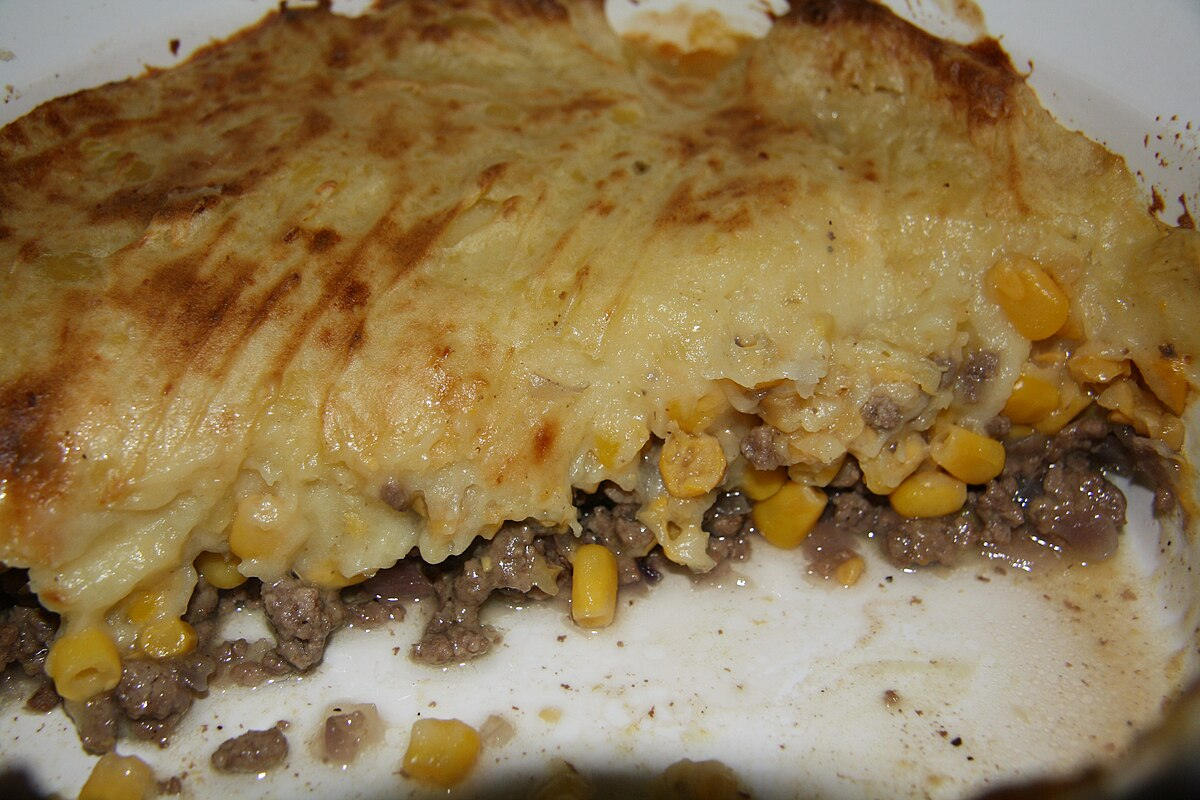
</center>